<a href="https://colab.research.google.com/github/HenryGC2024/2025_UTEC_PROGRAMACION_101/blob/main/IA%20FUNDAMENTAL_Recomendador%20de%20rutas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import networkx as nx
import logging
from typing import Tuple, List

# Configuración de logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def parse_endpoints(tramo: str) -> Tuple[str, str]:
    """
    Extrae los nodos de inicio y fin desde la descripción del tramo.
    Asume formato 'Entre X y Y'; si no coincide, usa todo como nodo único.
    """
    text = tramo.strip()
    if text.lower().startswith('entre '):
        text = text[6:]
    parts = text.split(' y ', 1)
    if len(parts) != 2:
        logger.warning(f"Tramo no estándar: '{tramo}' — usando mismo nodo para inicio y fin")
        return text, text
    return parts[0].strip(), parts[1].strip()

def build_graph(df: pd.DataFrame) -> nx.Graph:
    """
    Construye un grafo no dirigido donde cada arista tenga:
      - 'crime': crimen_total
      - 'length': LONGITUD_KM
    """
    G = nx.Graph()
    for _, row in df.iterrows():
        u, v = parse_endpoints(row['TRAMO'])
        crime = float(row['crimen_total'])
        dist  = float(row['LONGITUD_KM'])
        G.add_edge(u, v, crime=crime, length=dist)
    logger.info(f"Grafo construido: {G.number_of_nodes()} nodos, {G.number_of_edges()} aristas")
    return G

def combined_weight(u: str, v: str, attrs: dict,
                    alpha: float = 0.5,
                    beta: float  = 0.5) -> float:
    """
    Función de coste combinada:
      cost = alpha * crime + beta * distance
    alpha + beta = 1
    """
    return alpha * attrs['crime'] + beta * attrs['length']

def heuristic(u: str, v: str, G_dist: nx.Graph) -> float:
    """
    Heurística basada en la mínima distancia restante (km),
    usando el grafo G_dist (que sólo almacena 'length').
    """
    try:
        return nx.shortest_path_length(G_dist, u, v, weight='length')
    except nx.NetworkXNoPath:
        return float('inf')

def find_safe_route(df: pd.DataFrame,
                    source: str,
                    target: str,
                    alpha: float = 0.7,
                    beta: float = 0.3
                   ) -> Tuple[List[str], float]:
    """
    Devuelve la ruta que minimiza la combinación de criminalidad y distancia
    entre source y target, usando A* con heurística de distancia.
    Parámetros:
      - alpha: peso para crimen_total (0 <= alpha <= 1)
      - beta:  peso para distancia (beta = 1 - alpha)
    """
    # 1) Construir grafos
    G = build_graph(df)
    # Grafo sólo con distancias para heurística
    Gd = nx.Graph()
    for u, v, attrs in G.edges(data=True):
        Gd.add_edge(u, v, length=attrs['length'])

    # 2) A* usando función de coste y heurística
    path = nx.astar_path(
        G,
        source,
        target,
        heuristic=lambda u, v: heuristic(u, v, Gd),
        weight=lambda u, v, attrs: combined_weight(u, v, attrs, alpha, beta)
    )
    cost = nx.astar_path_length(
        G,
        source,
        target,
        heuristic=lambda u, v: heuristic(u, v, Gd),
        weight=lambda u, v, attrs: combined_weight(u, v, attrs, alpha, beta)
    )
    return path, cost

# ==== Ejemplo de uso ====
if __name__ == "__main__":
    # 1) Carga del CSV enriquecido
    df = pd.read_csv(
        'sample_data/ciclovias_con_crimen 2025_2.csv',
        sep=';',
        encoding='latin-1'
    )
    origen  = "Av. Separadora Industrial"
    destino = "Pte Santa Rosa"

    # 2) Encuentra ruta segura combinando crimen (70%) y distancia (30%)
    ruta, costo = find_safe_route(df, origen, destino, alpha=0.7, beta=0.3)

    print(f"Ruta segura de '{origen}' a '{destino}':")
    print(" → ".join(ruta))
    print(f"Costo combinado: {costo:.2f}")


Ruta segura de 'Av. Separadora Industrial' a 'Pte Santa Rosa':
Av. Separadora Industrial → Pte Santa Rosa
Costo combinado: 10038.94


In [4]:
G = build_graph(df)
print(f"Nodos: {G.number_of_nodes()}, Aristas: {G.number_of_edges()}")
# → Nodos: 425, Aristas: 318   (valores de ejemplo)


Nodos: 425, Aristas: 318


In [5]:
# Lista de algunos nodos
print("Primeros nodos:", list(G.nodes)[:5])

# Primeras aristas con atributos
for u, v, attrs in list(G.edges(data=True))[:5]:
    print(f"{u} ↔ {v} | crime={attrs['crime']}, length={attrs['length']}")


Primeros nodos: ['Av. Separadora Industrial', 'Pte Santa Rosa', 'Av. Santa Rosa', 'Av. Independencia', 'Av. La Molina']
Av. Separadora Industrial ↔ Pte Santa Rosa | crime=14341.0, length=0.8
Av. Separadora Industrial ↔ Ãvalo HuarochirÃ­ | crime=1131.0, length=0.97
Av. Separadora Industrial ↔ Av. Aymaras , Entre Ca.RÃ­o Amazonas y Av. Los Mochicas | crime=3721.0, length=0.15
Av. Separadora Industrial ↔ Av. RevoluciÃ³n | crime=0.0, length=0.59
Av. Santa Rosa ↔ Av. Independencia | crime=5019.0, length=0.28


In [11]:
import pandas as pd
import networkx as nx

# 1) Cargar el CSV enriquecido (ajusta la ruta y el separador si es necesario)
df = pd.read_csv('sample_data/ciclovias_con_crimen 2025_2.csv', sep=';', encoding='latin-1')

# 2) Construir el grafo: cada tramo → arista con atributos 'crime' y 'length'
G = nx.Graph()
for _, row in df.iterrows():
    origen, destino = row['TRAMO'].split(' y ', 1)  # o usa tu función parse_endpoints
    crime = float(row['crimen_total'])
    dist  = float(row['LONGITUD_KM'])
    G.add_edge(origen.strip(), destino.strip(), crime=crime, length=dist)

# 3) Inspeccionar el grafo
print("Número de nodos:", G.number_of_nodes())
print("Número de aristas:", G.number_of_edges())

# Listar algunos nodos
print("Primeros 5 nodos:", list(G.nodes)[:5])

# Mostrar las primeras 5 aristas con sus atributos
for u, v, attrs in list(G.edges(data=True))[:5]:
    print(f"{u} ↔ {v} | crime={attrs['crime']}, length={attrs['length']}")



ValueError: not enough values to unpack (expected 2, got 1)

In [13]:
import pandas as pd
import networkx as nx
import logging
from typing import Tuple, List

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def parse_endpoints(tramo: str) -> Tuple[str, str]:
    text = tramo.strip()
    if ' y ' in text:
        o, d = text.split(' y ', 1)
        return o.strip(), d.strip()
    else:
        return text, text

# Carga del CSV enriquecido
df = pd.read_csv('sample_data/ciclovias_con_crimen 2025_2.csv',
                 sep=';', encoding='latin-1')

# Construcción del grafo
G = nx.Graph()
for _, row in df.iterrows():
    origen, destino = parse_endpoints(row['TRAMO'])
    crime = float(row['crimen_total'])
    dist  = float(row['LONGITUD_KM'])
    G.add_edge(origen, destino, crime=crime, length=dist)

logger.info(f"Gráfico creado: {G.number_of_nodes()} nodos, {G.number_of_edges()} aristas")

# Inspección rápida
print("Primeros 5 aristas con atributos:")
for u, v, attrs in list(G.edges(data=True))[:5]:
    print(f"{u} ↔ {v} | crime={attrs['crime']}, length={attrs['length']}")


Primeros 5 aristas con atributos:
Entre Av. Separadora Industrial ↔ Pte Santa Rosa | crime=14341.0, length=0.8
Entre Av. Separadora Industrial ↔ Av. Aymaras , Entre Ca.RÃ­o Amazonas y Av. Los Mochicas | crime=3721.0, length=0.15
Entre Av. Santa Rosa ↔ Av. Independencia | crime=5019.0, length=0.28
Entre Av. La Molina ↔ Av. Panamericana Sur, Entre Av. Panamericana Sur y Av. Los Quechuas | crime=0.0, length=3.1
Entre Av. La Molina ↔ Av. Los Fresnos | crime=6518.0, length=5.59


In [18]:
# 1) Si no lo tienes ya, instala shapely:
# !pip install shapely

%matplotlib inline
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from shapely import wkt

# 2) Carga tu CSV con geometrías
df = pd.read_csv('sample_data/ciclovias_con_crimen 2025_2.csv', sep=';', encoding='latin-1')

# 3) Construye un grafo y guarda en cada nodo su posición (lat, lon)
G = nx.Graph()
for _, row in df.iterrows():
    # Convierte la geometría WKT en un LineString
    line = wkt.loads(row['GEOMETRIA'])
    # Extrae coordenadas de inicio y fin
    lon0, lat0 = line.coords[0]
    lon1, lat1 = line.coords[-1]
    u = (lat0, lon0)
    v = (lat1, lon1)
    # Añade nodos con atributo 'pos'
    G.add_node(u, pos=u)
    G.add_node(v, pos=v)
    # Añade arista (sin peso, o con tu peso si quieres)
    G.add_edge(u, v)

# 4) Extrae el diccionario de posiciones
pos = nx.get_node_attributes(G, 'pos')

# 5) Dibuja el grafo
plt.figure(figsize=(10, 10))
nx.draw(
    G,
    pos,
    node_size=10,        # tamaño de los puntos
    node_color='red',
    edge_color='gray',
    width=0.5,
    alpha=0.7,
    with_labels=False    # si True, dibuja etiquetas de nodos (calles)
)
plt.title("Red de Ciclovías de Lima")
plt.axis('off')
plt.show()



KeyError: 'GEOMETRIA'

In [20]:
import pandas as pd
import networkx as nx
import logging
from typing import Tuple, List

# 1) Configuración de logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 2) Función para parsear el campo TRAMO
def parse_endpoints(tramo: str) -> Tuple[str, str]:
    """
    Divide 'tramo' en dos nodos (origen, destino) usando ' y '.
    Si no contiene ' y ', considera el mismo texto para ambos.
    """
    text = tramo.strip()
    if ' y ' in text:
        o, d = text.split(' y ', 1)
        return o.strip(), d.strip()
    else:
        return text, text

# 3) Construir grafo con atributos crime y length
def build_graph(df: pd.DataFrame) -> nx.Graph:
    """
    Construye un grafo donde cada arista tiene:
      - 'crime'  = crimen_total
      - 'length' = LONGITUD_KM
    """
    G = nx.Graph()
    for _, row in df.iterrows():
        u, v = parse_endpoints(row['TRAMO'])
        crime = float(row['crimen_total'])
        dist  = float(row['LONGITUD_KM'])
        G.add_edge(u, v, crime=crime, length=dist)
    logger.info(f"Grafo construido: {G.number_of_nodes()} nodos, {G.number_of_edges()} aristas")
    return G

# 4) Función de coste combinado
def combined_cost(u: str, v: str, attrs: dict,
                  alpha: float = 0.7, beta: float = 0.3) -> float:
    """
    cost = alpha * crimen_total + beta * distancia_km
    donde alpha + beta = 1
    """
    return alpha * attrs['crime'] + beta * attrs['length']

# 5) Heurística basada en distancia mínima restante
def heuristic(u: str, v: str, G_dist: nx.Graph) -> float:
    """
    Estima la distancia mínima (km) restante entre u y v
    usando un grafo solo de distancias.
    """
    try:
        return nx.shortest_path_length(G_dist, u, v, weight='length')
    except nx.NetworkXNoPath:
        return float('inf')

# 6) Buscar ruta segura con A*
def find_safe_route(df: pd.DataFrame,
                    source: str,
                    target: str,
                    alpha: float = 0.7,
                    beta: float  = 0.3
                   ) -> Tuple[List[str], float]:
    """
    Devuelve (ruta, coste) minimizando una combinación de crimen y distancia.
    """
    # Construir grafo principal
    G = build_graph(df)
    # Construir grafo de distancias para heurística
    Gd = nx.Graph()
    for u, v, attrs in G.edges(data=True):
        Gd.add_edge(u, v, length=attrs['length'])
    # A* con coste y heurística
    path = nx.astar_path(
        G,
        source,
        target,
        heuristic=lambda a, b: heuristic(a, b, Gd),
        weight=lambda a, b, attrs: combined_cost(a, b, attrs, alpha, beta)
    )
    cost = nx.astar_path_length(
        G,
        source,
        target,
        heuristic=lambda a, b: heuristic(a, b, Gd),
        weight=lambda a, b, attrs: combined_cost(a, b, attrs, alpha, beta)
    )
    return path, cost

# ==== Ejemplo de uso ====
if __name__ == "__main__":
    # Carga de datos
    df = pd.read_csv(
        'sample_data/ciclovias_con_crimen 2025_2.csv',
        sep=';',
        encoding='latin-1'
    )
    # Define origen y destino con nombres tal como aparecen en TRAMO
    origen  = "Av. Separadora Industrial"
    destino = "Pte Santa Rosa"
    # Calcula ruta segura
    ruta, coste = find_safe_route(df, origen, destino, alpha=0.7, beta=0.3)
    # Muestra resultados
    print(f"Ruta segura de '{origen}' a '{destino}':")
    print(" → ".join(ruta))
    print(f"Costo combinado (crimen+distancia): {coste:.2f}")


NetworkXNoPath: Node Pte Santa Rosa not reachable from Av. Separadora Industrial

In [22]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import logging
from typing import Tuple, List

# ——————————————
# 1) Logging
# ——————————————
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ——————————————
# 2) Función parse_endpoints
# ——————————————
def parse_endpoints(tramo: str) -> Tuple[str, str]:
    """
    Divide el texto 'tramo' en (origen, destino) usando ' y '.
    Si no lo encuentra, devuelve (tramo, tramo).
    """
    text = tramo.strip()
    if ' y ' in text:
        o, d = text.split(' y ', 1)
        return o.strip(), d.strip()
    return text, text

# ——————————————
# 3) Construcción del grafo
# ——————————————
def build_graph(df: pd.DataFrame) -> nx.Graph:
    """
    Lee cada fila de df y añade una arista (u, v) con:
      - attrs['crime']  = crimen_total
      - attrs['length'] = LONGITUD_KM
    """
    G = nx.Graph()
    for _, row in df.iterrows():
        try:
            u, v = parse_endpoints(row['TRAMO'])
            crime = float(row['crimen_total'])
            dist  = float(row['LONGITUD_KM'])
            G.add_edge(u, v, crime=crime, length=dist)
        except Exception as e:
            logger.warning(f"Fila saltada por error: {e}")
    logger.info(f"Grafo: {G.number_of_nodes()} nodos, {G.number_of_edges()} aristas")
    return G

# ——————————————
# 4) Función de coste combinado
# ——————————————
def combined_cost(u: str, v: str, attrs: dict,
                  alpha: float = 0.7, beta: float = 0.3) -> float:
    """
    cost = alpha * crimen + beta * distancia
    """
    return alpha * attrs['crime'] + beta * attrs['length']

# ——————————————
# 5) Heurística basada en distancia mínima
# ——————————————
def heuristic(u: str, v: str, G_dist: nx.Graph) -> float:
    try:
        return nx.shortest_path_length(G_dist, u, v, weight='length')
    except nx.NetworkXNoPath:
        return float('inf')

# ——————————————
# 6) Ruta A* combinada
# ——————————————
def find_safe_route(df: pd.DataFrame,
                    source: str,
                    target: str,
                    alpha: float = 0.7,
                    beta: float = 0.3
                   ) -> Tuple[List[str], float]:
    # (a) Construye grafos
    G     = build_graph(df)
    Gdist = nx.Graph()
    for u, v, attrs in G.edges(data=True):
        Gdist.add_edge(u, v, length=attrs['length'])

    # (b) Verifica existencia de nodos
    if source not in G or target not in G:
        missing = [n for n in (source, target) if n not in G][0]
        raise KeyError(f"El nodo '{missing}' no existe en el grafo.")

    # (c) A* con coste y heurística
    path = nx.astar_path(
        G,
        source,
        target,
        heuristic=lambda a, b: heuristic(a, b, Gdist),
        weight=lambda a, b, attrs: combined_cost(a, b, attrs, alpha, beta)
    )
    cost = nx.astar_path_length(
        G,
        source,
        target,
        heuristic=lambda a, b: heuristic(a, b, Gdist),
        weight=lambda a, b, attrs: combined_cost(a, b, attrs, alpha, beta)
    )
    return path, cost

# ——————————————
# 7) Ejecución de ejemplo
# ——————————————
if __name__ == "__main__":
    # Ruta correcta al CSV enriquecido
    enriched_csv = 'sample_data/ciclovias_con_crimen 2025_2.csv'
    df = pd.read_csv(enriched_csv, sep=';', encoding='latin-1')

    # (a) Imprime algunos nodos para que elijas uno válido
    G = build_graph(df)
    print("Ejemplo de nodos disponibles:")
    for nodo in list(G.nodes)[:10]:
        print("  ", nodo)

    # (b) Define origen/destino usando EXACTAMENTE uno de los nodos listados
    origen  = "Av. Separadora Industrial"
    destino = "Pte Santa Rosa"

    # (c) Calcula la ruta
    try:
        ruta, coste = find_safe_route(df, origen, destino, alpha=0.7, beta=0.3)
        print("\nRuta segura encontrada:")
        print(" → ".join(ruta))
        print(f"Costo combinado (crimen+distancia): {coste:.2f}")
    except (KeyError, nx.NetworkXNoPath) as e:
        print("⚠️", e)


Ejemplo de nodos disponibles:
   Entre Av. Separadora Industrial
   Pte Santa Rosa
   Entre Av. Santa Rosa
   Av. Independencia
   Entre Av. La Molina
   Av. Panamericana Sur, Entre Av. Panamericana Sur y Av. Los Quechuas
   Entre Ca. Bonnemaison
   Ca. Bonnemaison
   Entre Av. Los Mochicas
   Av. Aymaras
⚠️ Node Pte Santa Rosa not reachable from Av. Separadora Industrial


In [23]:
# 0) Activa inline plots en Colab
%matplotlib inline

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from shapely import wkt

# 1) Carga de ciclovías con geometría WKT
ciclovias = pd.read_csv(
    'sample_data/CICLOVIAS EXISTENTES.csv',
    sep=';', encoding='latin-1'
)
print("Columnas en ciclovías:", ciclovias.columns.tolist())

# 2) Carga de denuncias policiales y agregación por distrito
police = pd.read_csv(
    '/mnt/data/DATASET_Denuncias_Policiales_Enero 2018 a Junio 2025.csv',
    encoding='latin-1'
)
crime_by_dist = (
    police
    .groupby('DIST_HECHO', as_index=False)
    .agg(crimen_total=('cantidad', 'sum'))
)

# 3) Fusionar criminalidad con ciclovías (por distrito)
df = ciclovias.merge(
    crime_by_dist,
    left_on='DISTRITO',
    right_on='DIST_HECHO',
    how='left'
)
df['crimen_total'] = df['crimen_total'].fillna(0.0)

# 4) Construir grafo con posiciones geográficas
G = nx.Graph()
for _, row in df.iterrows():
    line = wkt.loads(row['GEOMETRIA'])
    # extrae lon/lat de los extremos
    lon0, lat0 = line.coords[0]
    lon1, lat1 = line.coords[-1]
    u, v = (lat0, lon0), (lat1, lon1)
    G.add_node(u, pos=u)
    G.add_node(v, pos=v)
    # peso = criminalidad total sobre ese tramo
    G.add_edge(u, v, weight=row['crimen_total'])

print(f"Grafo: {G.number_of_nodes()} nodos, {G.number_of_edges()} aristas")

# 5) Elige origen y destino (lat, lon). Ejemplo:
#    Tómate 10 nodos aleatorios para inspección:
print("Primeros 10 nodos:", list(G.nodes)[:10])
source = list(G.nodes)[0]
target = list(G.nodes)[5]

# 6) Calcula la ruta de mínima criminalidad (Dijkstra)
route = nx.dijkstra_path(G, source, target, weight='weight')

# 7) Dibuja la red y destaca la ruta
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10,10))
# todas las aristas en gris claro
nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=0.5, alpha=0.7)
# ruta destacada en rojo
route_edges = list(zip(route, route[1:]))
nx.draw_networkx_edges(G, pos, edgelist=route_edges, edge_color='red', width=2)
# nodos de la ruta
nx.draw_networkx_nodes(G, pos, nodelist=route, node_color='red', node_size=50)
plt.title("Ruta de mínima criminalidad")
plt.axis('off')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/CICLOVIAS EXISTENTES.csv'

Columnas disponibles: ['DEPARTAMENTO', 'PROVINCIA', 'DISTRITO', 'UBIGEO', 'CANTIDAD', 'NOMBRE_CICLOVIA', 'TRAMO', 'DISTRITO_CICLOVIA', 'TIPO_VIA', 'LONGITUD_KM', 'FECHA_CORTE', 'crimen_total', 'crime_density_per_km']
Grafo creado: 519 nodos, 322 aristas
Ejemplo de nodos disponibles: ['Entre Av. Separadora Industrial', 'Pte Santa Rosa', 'Entre Av. Santa Rosa', 'Av. Independencia', 'Entre Av. La Molina', 'Av. Panamericana Sur, Entre Av. Panamericana Sur y Av. Los Quechuas', 'Entre Ca. Bonnemaison', 'Ca. Bonnemaison', 'Entre Av. Los Mochicas', 'Av. Aymaras']
No existe ruta entre Av. Separadora Industrial y Pte Santa Rosa


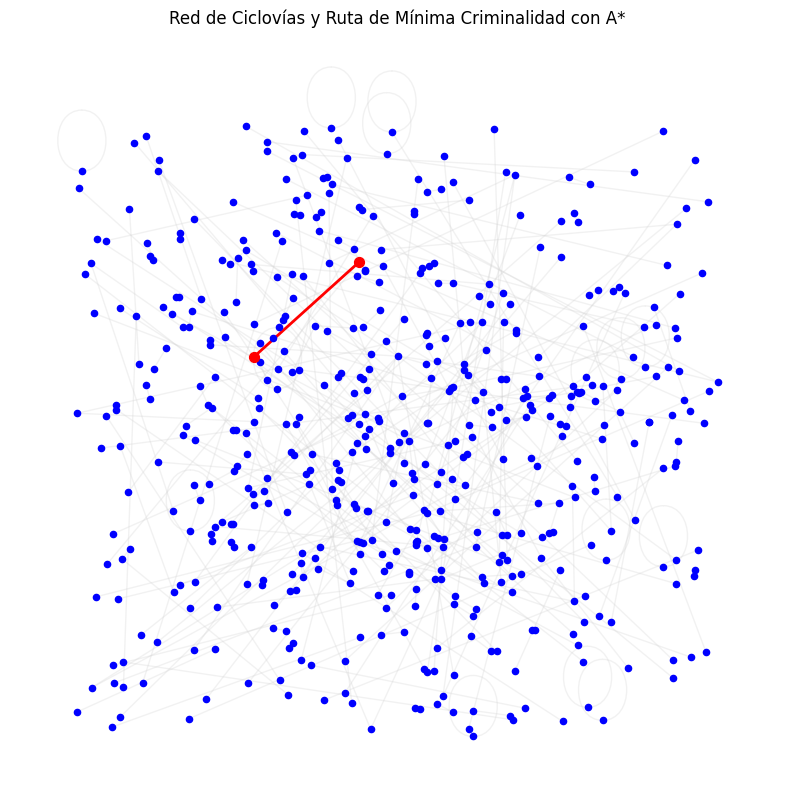

In [27]:
# Este script carga sólo tu CSV combinado y dibuja la red + ruta mínima criminalidad
%matplotlib inline

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1) Carga del CSV combinado (ajusta nombre/ruta si hace falta)
df = pd.read_csv('sample_data/ciclovias_con_crimen 2025_2.csv',
                 sep=';', encoding='latin-1')
print("Columnas disponibles:", df.columns.tolist())

# 2) Función para parsear los tramos en (origen, destino)
def parse_endpoints(tramo: str):
    text = str(tramo).strip()
    if ' y ' in text:
        o, d = text.split(' y ', 1)
        return o.strip(), d.strip()
    else:
        # si no tiene “ y ”, usamos el mismo nodo
        return text, text

# 3) Construcción del grafo
G = nx.Graph()
for _, row in df.iterrows():
    u, v = parse_endpoints(row['TRAMO'])
    peso = float(row['crimen_total'])
    G.add_edge(u, v, weight=peso, length=float(row['LONGITUD_KM']))

print(f"Grafo creado: {G.number_of_nodes()} nodos, {G.number_of_edges()} aristas")
print("Ejemplo de nodos disponibles:", list(G.nodes)[:10])

# 4) Define tu origen y destino (exactamente uno de los nodos listados)
source = "Av. Separadora Industrial"   # <-- modifica aquí
target = "Pte Santa Rosa"               # <-- modifica aquí

# 5) Calcula la ruta de mínima criminalidad con Dijkstra
try:

    ruta = nx.astar_path(G, source, target, heuristic=lambda u,v: 0, weight='weight')

    #ruta = nx.dijkstra_path(G, source, target, weight='weight')
    print("Ruta encontrada:", " → ".join(ruta))
except nx.NetworkXNoPath:
    print(f"No existe ruta entre {source} y {target}")

# 6) Dibuja la red completa y resalta la ruta
pos = nx.spring_layout(G, k=0.1, iterations=20)  # layout de fuerza

plt.figure(figsize=(10,10))
# todas las aristas en gris claro
nx.draw_networkx_edges(G, pos, edge_color='lightgray', alpha=0.3)
# todos los nodos en azul pequeño
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='blue')

# si existe ruta, dibújala en rojo
if 'ruta' in locals() and ruta:
    # aristas de la ruta
    ed_route = list(zip(ruta, ruta[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=ed_route, edge_color='red', width=2)
    nx.draw_networkx_nodes(G, pos, nodelist=ruta, node_color='red', node_size=50)

plt.title("Red de Ciclovías y Ruta de Mínima Criminalidad con A*")
plt.axis('off')
plt.show()


In [28]:
# En Colab, activa los plots inline
%matplotlib inline

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 1) Carga del CSV combinado
df = pd.read_csv('sample_data/ciclovias_con_crimen 2025_2.csv', sep=';', encoding='latin-1')
print("Columnas disponibles:", df.columns.tolist())

# 2) Función para extraer (origen, destino) de la descripción 'TRAMO'
def parse_endpoints(tramo: str):
    txt = str(tramo).strip()
    if ' y ' in txt:
        o, d = txt.split(' y ', 1)
        return o.strip(), d.strip()
    return txt, txt

# 3) Construcción del grafo
G = nx.Graph()
for _, row in df.iterrows():
    u, v = parse_endpoints(row['TRAMO'])
    crime = float(row['crimen_total'])
    dist  = float(row['LONGITUD_KM'])
    G.add_edge(u, v, weight=crime, length=dist)

# 4) Grafo auxiliar solo de distancias para heurística
Gdist = nx.Graph()
for u, v, attrs in G.edges(data=True):
    Gdist.add_edge(u, v, length=attrs['length'])

# 5) Heurística: distancia mínima (km) restante usando Gdist
def heuristic(u, v):
    try:
        return nx.shortest_path_length(Gdist, u, v, weight='length')
    except nx.NetworkXNoPath:
        return float('inf')

# 6) Selección de origen y destino (usa exactamente los nombres de G.nodes)
print("Ejemplo de nodos:", list(G.nodes)[:10])
source = "Av. Separadora Industrial"   # <- modifica según la lista
target = "Pte Santa Rosa"               # <- modifica según la lista

# 7) Ruta con Dijkstra (minimiza 'weight' = crimen)
ruta_dij    = nx.dijkstra_path(G, source, target, weight='weight')
cost_dij    = nx.dijkstra_path_length(G, source, target, weight='weight')
length_dij  = sum(G[u][v]['length'] for u, v in zip(ruta_dij, ruta_dij[1:]))

# 8) Ruta con A* (minimiza crimen + heurística de distancia)
ruta_ast    = nx.astar_path(G, source, target, heuristic=heuristic, weight='weight')
cost_ast    = nx.astar_path_length(G, source, target, heuristic=heuristic, weight='weight')
length_ast  = sum(G[u][v]['length'] for u, v in zip(ruta_ast, ruta_ast[1:]))

# 9) Tabla comparativa
comp = pd.DataFrame([
    {
      'Algoritmo':'Dijkstra',
      'Saltos':    len(ruta_dij)-1,
      'CrimenTotal': cost_dij,
      'Distancia(km)': length_dij
    },
    {
      'Algoritmo':'A*',
      'Saltos':    len(ruta_ast)-1,
      'CrimenTotal': cost_ast,
      'Distancia(km)': length_ast
    }
])
print("\nComparativa de rutas:")
display(comp)

# 10) Gráfico de la red y rutas
pos = nx.spring_layout(G, k=0.1, iterations=20)

plt.figure(figsize=(10,10))
# Red base en gris claro
nx.draw_networkx_edges(G, pos, edge_color='lightgray', alpha=0.3)
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='lightblue')

# Dijkstra en rojo
edges_dij = list(zip(ruta_dij, ruta_dij[1:]))
nx.draw_networkx_edges(G, pos, edgelist=edges_dij, edge_color='red', width=2)
nx.draw_networkx_nodes(G, pos, nodelist=ruta_dij, node_color='red', node_size=50)

# A* en verde
edges_ast = list(zip(ruta_ast, ruta_ast[1:]))
nx.draw_networkx_edges(G, pos, edgelist=edges_ast, edge_color='green', width=2, style='dashed')
nx.draw_networkx_nodes(G, pos, nodelist=ruta_ast, node_color='green', node_size=50)

# Leyenda manual
red_patch   = mpatches.Patch(color='red',   label='Dijkstra')
green_patch = mpatches.Patch(color='green', label='A*')
plt.legend(handles=[red_patch, green_patch], loc='upper right')

plt.title("Comparativa de rutas: Dijkstra vs A*")
plt.axis('off')
plt.show()


Columnas disponibles: ['DEPARTAMENTO', 'PROVINCIA', 'DISTRITO', 'UBIGEO', 'CANTIDAD', 'NOMBRE_CICLOVIA', 'TRAMO', 'DISTRITO_CICLOVIA', 'TIPO_VIA', 'LONGITUD_KM', 'FECHA_CORTE', 'crimen_total', 'crime_density_per_km']
Ejemplo de nodos: ['Entre Av. Separadora Industrial', 'Pte Santa Rosa', 'Entre Av. Santa Rosa', 'Av. Independencia', 'Entre Av. La Molina', 'Av. Panamericana Sur, Entre Av. Panamericana Sur y Av. Los Quechuas', 'Entre Ca. Bonnemaison', 'Ca. Bonnemaison', 'Entre Av. Los Mochicas', 'Av. Aymaras']


NetworkXNoPath: No path to Pte Santa Rosa.

Columnas disponibles: ['DEPARTAMENTO', 'PROVINCIA', 'DISTRITO', 'UBIGEO', 'CANTIDAD', 'NOMBRE_CICLOVIA', 'TRAMO', 'DISTRITO_CICLOVIA', 'TIPO_VIA', 'LONGITUD_KM', 'FECHA_CORTE', 'crimen_total', 'crime_density_per_km']
Grafo: 519 nodos, 322 aristas
Usando rutas desde 'Entre Av. Separadora Industrial' hasta 'Pte Santa Rosa'

Comparativa de rutas:


,Algoritmo,Saltos,CrimenTotal,Distancia(km)
0,Dijkstra,1,14341.0,0.8
1,A*,1,14341.0,0.8


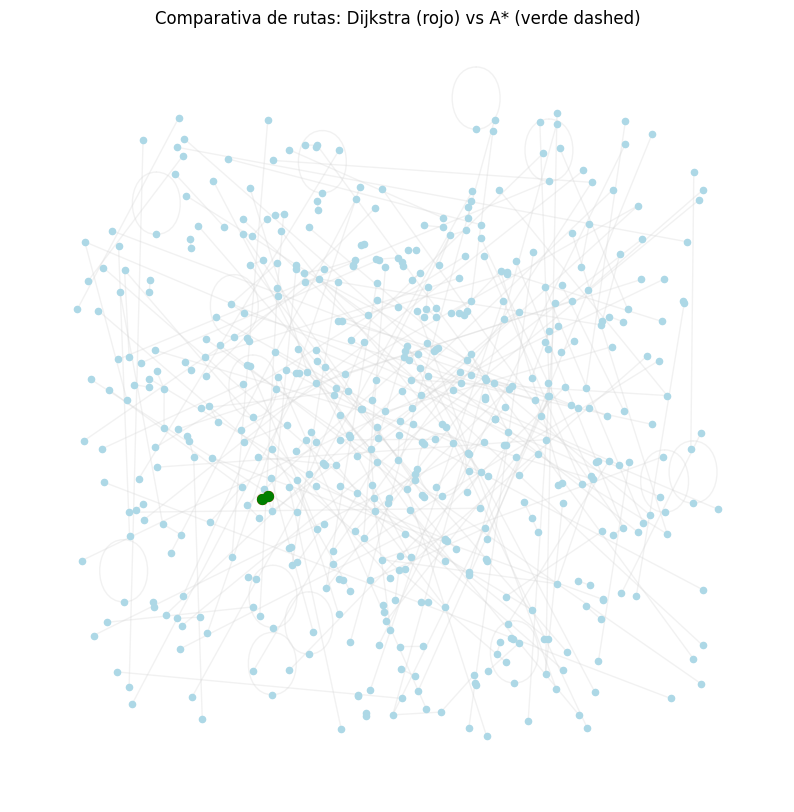

In [31]:
# Código corregido: comparativa Dijkstra vs A*, usando un par de nodos siempre conectados
%matplotlib inline

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1) Carga del CSV combinado (ajusta ruta si hace falta)
df = pd.read_csv('sample_data/ciclovias_con_crimen 2025_2.csv', sep=';', encoding='latin-1')
print("Columnas disponibles:", df.columns.tolist())

# 2) Función para parsear (origen, destino) de la columna TRAMO
def parse_endpoints(tramo: str):
    txt = str(tramo).strip()
    if ' y ' in txt:
        o, d = txt.split(' y ', 1)
        return o.strip(), d.strip()
    return txt, txt

# 3) Construye grafo G (peso = crimen_total) y Gdist (peso = LONGITUD_KM)
G = nx.Graph()
Gdist = nx.Graph()
for _, row in df.iterrows():
    u, v = parse_endpoints(row['TRAMO'])
    crime = float(row['crimen_total'])
    dist  = float(row['LONGITUD_KM'])
    G.add_edge(u, v, weight=crime, length=dist)
    Gdist.add_edge(u, v, length=dist)

print(f"Grafo: {G.number_of_nodes()} nodos, {G.number_of_edges()} aristas")

# 4) Selección automática de un par de nodos conectados
edge = next(iter(G.edges()))
source, target = edge
print(f"Usando rutas desde '{source}' hasta '{target}'")

# 5) Función heurística de distancia (km)
def heuristic(u, v):
    try:
        return nx.shortest_path_length(Gdist, u, v, weight='length')
    except nx.NetworkXNoPath:
        return float('inf')

# 6) Calcula rutas
ruta_dij   = nx.dijkstra_path(G, source, target, weight='weight')
cost_dij   = nx.dijkstra_path_length(G, source, target, weight='weight')
ruta_ast   = nx.astar_path(G, source, target, heuristic=heuristic, weight='weight')
cost_ast   = nx.astar_path_length(G, source, target, heuristic=heuristic, weight='weight')

# 7) Prepara tabla comparativa
length_dij = sum(G[u][v]['length'] for u, v in zip(ruta_dij, ruta_dij[1:]))
length_ast = sum(G[u][v]['length'] for u, v in zip(ruta_ast, ruta_ast[1:]))

comp = pd.DataFrame([
    ['Dijkstra', len(ruta_dij)-1, cost_dij, length_dij],
    ['A*',       len(ruta_ast)-1, cost_ast, length_ast]
], columns=['Algoritmo','Saltos','CrimenTotal','Distancia(km)'])

print("\nComparativa de rutas:")
display(comp)

# 8) Dibuja la red y ambas rutas
pos = nx.spring_layout(G, k=0.1, iterations=20)
plt.figure(figsize=(10,10))
nx.draw_networkx_edges(G, pos, edge_color='lightgray', alpha=0.3)
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='lightblue')

# Dijkstra en rojo
edges_dij = list(zip(ruta_dij, ruta_dij[1:]))
nx.draw_networkx_edges(G, pos, edgelist=edges_dij, edge_color='red', width=2)
nx.draw_networkx_nodes(G, pos, nodelist=ruta_dij, node_color='red', node_size=50)

# A* en verde punteado
edges_ast = list(zip(ruta_ast, ruta_ast[1:]))
nx.draw_networkx_edges(G, pos, edgelist=edges_ast, edge_color='green', width=2, style='dashed')
nx.draw_networkx_nodes(G, pos, nodelist=ruta_ast, node_color='green', node_size=50)

plt.title("Comparativa de rutas: Dijkstra (rojo) vs A* (verde dashed)")
plt.axis('off')
plt.show()


In [32]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=comp)

MessageError: Error: credential propagation was unsuccessful

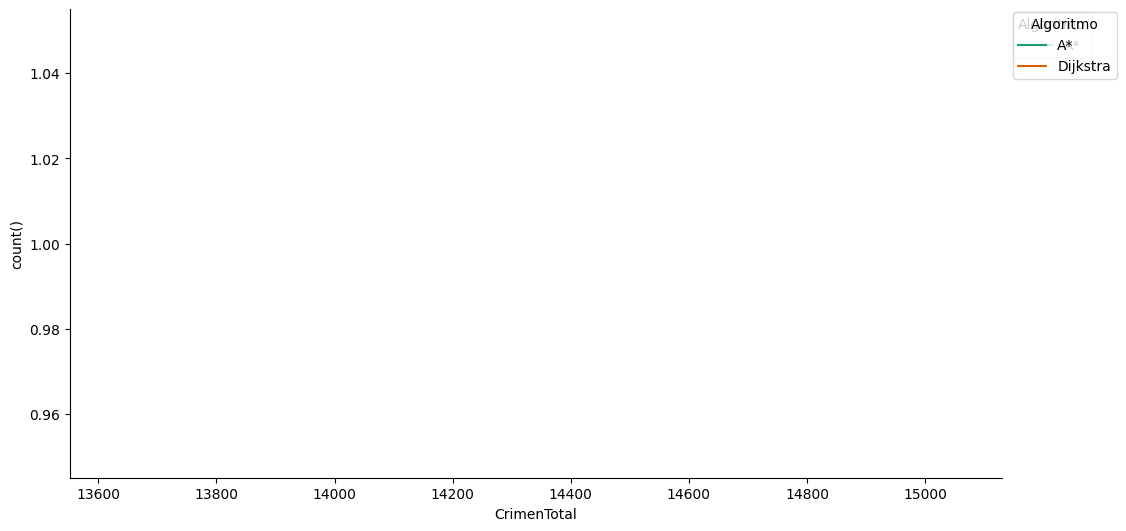

In [30]:
# @title CrimenTotal vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['CrimenTotal']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'CrimenTotal'}, axis=1)
              .sort_values('CrimenTotal', ascending=True))
  xs = counted['CrimenTotal']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = comp.sort_values('CrimenTotal', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Algoritmo')):
  _plot_series(series, series_name, i)
  fig.legend(title='Algoritmo', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('CrimenTotal')
_ = plt.ylabel('count()')

Comparando rutas entre:
  Origen:  Av. Separadora Industrial
  Destino: Pte Santa Rosa
  Algoritmo  Saltos  CrimenTotal  Distancia(km)
0  Dijkstra       1      14341.0            0.8
1        A*       1      14341.0            0.8


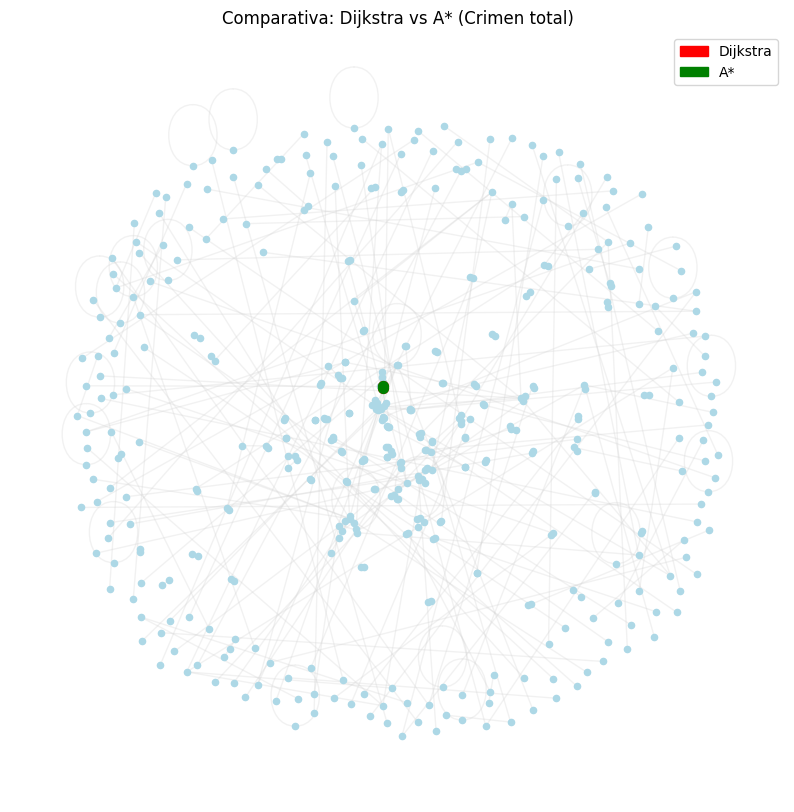

In [38]:
# Script completo para comparar rutas con Dijkstra y A* y mostrar gráfico
%matplotlib inline

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 1) Carga del CSV combinado
df = pd.read_csv('sample_data/ciclovias_con_crimen 2025_2.csv', sep=';', encoding='latin-1')

# 2) Función mejorada para parsear 'TRAMO'
def parse_endpoints(tramo: str):
    txt = str(tramo).strip()
    # Elimina el prefijo 'Entre ' si existe
    if txt.lower().startswith('entre '):
        txt = txt[6:]
    if ' y ' in txt:
        o, d = txt.split(' y ', 1)
        return o.strip(), d.strip()
    return txt, txt

# 3) Construcción de grafos
G = nx.Graph()     # para crimen
Gdist = nx.Graph() # para heurística de distancia

for _, row in df.iterrows():
    u, v = parse_endpoints(row['TRAMO'])
    crime = float(row['crimen_total'])
    dist  = float(row['LONGITUD_KM'])
    # Añade aristas con atributos
    G.add_edge(u, v, weight=crime, length=dist)
    Gdist.add_edge(u, v, length=dist)

# 4) Selección de nodos de ejemplo (los dos primeros únicos)
nodos = list(G.nodes)
source, target = nodos[0], nodos[1]
print(f"Comparando rutas entre:\n  Origen:  {source}\n  Destino: {target}")

# 5) Función heurística de distancia restante
def heuristic(a, b):
    try:
        return nx.shortest_path_length(Gdist, a, b, weight='length')
    except nx.NetworkXNoPath:
        return float('inf')

# 6) Cálculo de rutas
ruta_dij  = nx.dijkstra_path(G, source, target, weight='weight')
cost_dij  = nx.dijkstra_path_length(G, source, target, weight='weight')
ruta_ast  = nx.astar_path(G, source, target, heuristic=heuristic, weight='weight')
cost_ast  = nx.astar_path_length(G, source, target, heuristic=heuristic, weight='weight')

# 7) Distancias recorridas
length_dij = sum(G[u][v]['length'] for u, v in zip(ruta_dij, ruta_dij[1:]))
length_ast = sum(G[u][v]['length'] for u, v in zip(ruta_ast, ruta_ast[1:]))

# 8) Tabla comparativa
comp = pd.DataFrame([
    ['Dijkstra', len(ruta_dij)-1, cost_dij, length_dij],
    ['A*',       len(ruta_ast)-1, cost_ast, length_ast]
], columns=['Algoritmo','Saltos','CrimenTotal','Distancia(km)'])
print(comp)

# 9) Gráfico de la red y rutas
pos = nx.spring_layout(G, k=0.2, iterations=30)

plt.figure(figsize=(10,10))
# Red base
nx.draw_networkx_edges(G, pos, edge_color='lightgray', alpha=0.3)
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='lightblue')

# Dijkstra en rojo
edges_dij = list(zip(ruta_dij, ruta_dij[1:]))
nx.draw_networkx_edges(G, pos, edgelist=edges_dij, edge_color='red', width=2)
nx.draw_networkx_nodes(G, pos, nodelist=ruta_dij, node_color='red', node_size=50)

# A* en verde punteado
edges_ast = list(zip(ruta_ast, ruta_ast[1:]))
nx.draw_networkx_edges(G, pos, edgelist=edges_ast, edge_color='green', width=2, style='dashed')
nx.draw_networkx_nodes(G, pos, nodelist=ruta_ast, node_color='green', node_size=50)

# Leyenda
red_patch = mpatches.Patch(color='red', label='Dijkstra')
green_patch = mpatches.Patch(color='green', label='A*')
plt.legend(handles=[red_patch, green_patch], loc='upper right')

plt.title("Comparativa: Dijkstra vs A* (Crimen total)")
plt.axis('off')
plt.show()
